## Replication code for
# Estimation of DSGE Models with the Effective Lower Bound
and
# The Empirical Performance of the Financial Accelerator since 2008
### Gregor Boehl and Felix Strobel
The two papers used to be one, and are thus pretty similar in terms of methodology and code.

First, install the necessary packages. Do this either here (uncomment the cell below) or with your prefered package manager.

In [1]:
#!pip install pydsge
#!pip install requests

Do some imports:

In [2]:
# imports
import requests
import tempfile
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from pydsge import DSGE
from grgrlib import *

# plotting setup
plt.rc('text', usetex=True)

# if you run this in a jupyter notebook:
%matplotlib inline

All estimations and simulations are done using my pydsge package. The documentation of the package can be found here:
https://pydsge.readthedocs.io

All the estimations were run using a script that looks like this: https://github.com/gboehl/projectlib/blob/master/bczlb_BS/estimation_scipt.py

The YAML files can be found here, in particular the RANK and FRANK models: 
https://github.com/gboehl/projectlib/tree/master/yamls

For the rest of this notebook I will assume that the estimations are done, and the files which contain the results exists.

The following cell will download these results for the method paper. Be sure to do this only once as it takes some time - these are large files.

In [3]:
urls = (
    "https://gregorboehl.com/data/rank_spreads_exo_ztrend_SW_BAA_6420_ninit_0_meta.npz",
    "https://gregorboehl.com/data/rank_spreads_exo_ztrend_SW_BAA_6420_ninit_0_res.npz",
    "https://gregorboehl.com/data/rank_spreads_exo_ztrend_SW_BAA_6420_ninit_0_sampler.h5",
    "https://gregorboehl.com/data/rank_spreads_exo_ztrend_SW_BAA_6408_ninit_0_meta.npz",
    "https://gregorboehl.com/data/rank_spreads_exo_ztrend_SW_BAA_6408_ninit_0_res.npz", 
    "https://gregorboehl.com/data/rank_spreads_exo_ztrend_SW_BAA_6408_ninit_0_sampler.h5",
)

# create termporary directory
tmpdir = tempfile.TemporaryDirectory()
tmpdirname = tmpdir.name

for url in urls:

    # download file
    dl = requests.get(url)
    # get filename and path
    filename = os.path.basename(url)
    path = os.path.join(tmpdirname, filename)

    # write to file
    with open(path, 'wb') as f:
        f.write(dl.content)

The historical decomposition in Figure 1 and 3 of "Estimations" can be done just as in the [tutorial](https://pydsge.readthedocs.io/en/latest/getting_started.html#Historic-decompositions).

To obtain the series of shocks for the short sample starting 1998, we have to re-run the extraction routine (using the `extract()` method of the model with the short data sample, but using the parameters from the long sample). This may take some time. The historical shock decomposition in Figure 3 is done in exactly the same way, but using the parameters from the pre-crisis estimation (commented code below).

## Figure 2 of "Estimation..."

In [4]:
# get the location of the estimation data
dfile0 = os.path.join(tmpdirname, 'rank_spreads_exo_ztrend_SW_BAA_6420_ninit_0_meta.npz')

# parse and load the estimation data
mod0 = DSGE.load(dfile0, force_parse=False)
mod0.load_estim()
parm0 = mod0.get_par('post_mean', full=True)

[estimation:]   Model operational. 56 states, 8 observables, 8 shocks, 224 data points.
Adding parameters to the prior distribution...
   - sig_c as normal (1.5, 0.375). Init @ 1.2312, with bounds (0.25, 3)
   - sig_l as normal (2, 0.75). Init @ 2.8401, with bounds (-0.5, 6)
   - tpr_beta as gamma (0.25, 0.1). Init @ 0.742, with bounds (0.01, 1.0)
   - h as beta (0.7, 0.1). Init @ 0.7205, with bounds (0.3, 0.95)
   - phiss as normal (4, 1.5). Init @ 6.3325, with bounds (2, 12)
   - i_p as beta (0.5, 0.15). Init @ 0.3291, with bounds (0.01, 0.9)
   - i_w as beta (0.5, 0.15). Init @ 0.4425, with bounds (0.01, 0.9)
   - alpha as normal (0.3, 0.05). Init @ 0.24, with bounds (0.05, 0.4)
   - zeta_p as beta (0.5, 0.1). Init @ 0.7813, with bounds (0.4, 0.99)
   - zeta_w as beta (0.5, 0.1). Init @ 0.7937, with bounds (0.4, 0.99)
   - Phi_p as normal (1.25, 0.125). Init @ 1.4672, with bounds (1.0, 2.0)
   - psi as beta (0.5, 0.15). Init @ 0.2648, with bounds (0.01, 0.99)
   - phi_pi as normal (

In [5]:
# load the shock series from storage
epsd0 = mod0.load_rdict()
pars0 = epsd0['pars']

# and simulate again to obtain ZLB durations
msk = mod0.mask
l0,k0 = mod0.simulate(epsd0, msk)[1]
k0e = np.expand_dims(k0,2)

In [6]:
# get indices of intrest
s = mod0.data.index.slice_indexer('2008Q1','2016Q4')

i0 = mod0.data.index.get_loc('2009Q1')
i1 = mod0.data.index.get_loc('2011Q1')
i2 = mod0.data.index.get_loc('2012Q1')
i3 = mod0.data.index.get_loc('2013Q1')

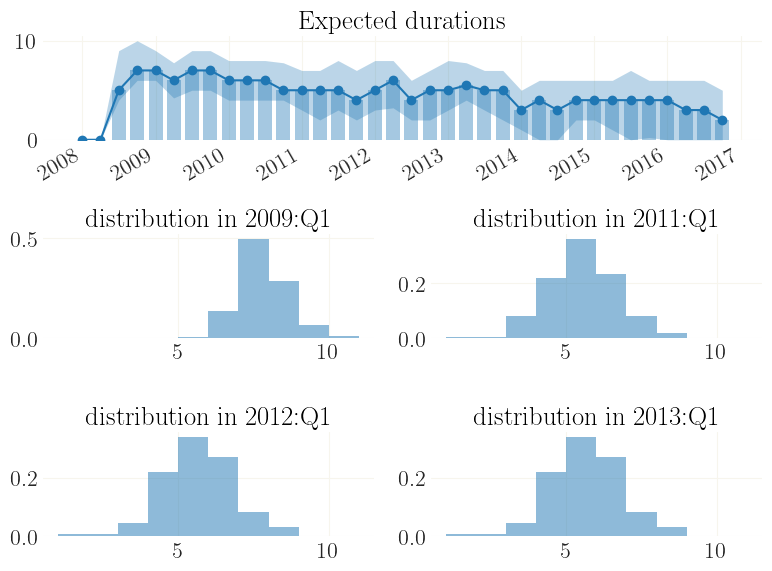

In [7]:
# plotting
sigma = .1
interval = np.nanpercentile(k0, [sigma*100/2, (1 - sigma/2)*100], axis=0)
median = np.nanmedian(k0, axis=0)

fig = plt.figure(figsize=(8,6))
ax0 = plt.subplot(311)
ax1 = plt.subplot(323)
ax2 = plt.subplot(324)
ax3 = plt.subplot(325)
ax4 = plt.subplot(326)
axformater(ax0)

pplot(k0e[:,s], mod0.data.index[s], ax=ax0, styles='-o')
ax0.bar(mod0.data.index[s], median[s], width=70, alpha=.4, color='C0')
ax0.set_title('Expected durations')
ax1.hist(k0[:,i0], np.arange(12)[1:], alpha=.5, density=True)
ax1.set_title('distribution in 2009:Q1')
ax2.hist(k0[:,i1], np.arange(12)[1:], alpha=.5, density=True)
ax2.set_title('distribution in 2011:Q1')
ax3.hist(k0[:,i2], np.arange(12)[1:], alpha=.5, density=True)
ax3.set_title('distribution in 2012:Q1')
ax4.hist(k0[:,i2], np.arange(12)[1:], alpha=.5, density=True)
ax4.set_title('distribution in 2013:Q1')
fig.tight_layout()

## Figure 4 of "Estimations..."

In [8]:
# load model with pre-crisis data
dfile1 = os.path.join(tmpdirname, 'rank_spreads_exo_ztrend_SW_BAA_6408_ninit_0_meta.npz')
mod1 = DSGE.load(dfile1, force_parse=False)

In [9]:
# get parameters from posterior
N = 250
pars0 = mod0.get_par('posterior', nsamples=N)
pars1 = mod1.get_par('posterior', nsamples=N)
pmea0 = mod0.get_par('post_mean')
pmea1 = mod1.get_par('post_mean')

In [10]:
# simulate IRFs
ir00 = mod0.irfs(('e_u',mod0.get_par('sig_u', pmea0),0), pars0)[0]
ir01 = mod1.irfs(('e_u',mod1.get_par('sig_u', pmea1),0), pars1)[0]

In [11]:
# prepare simulated data for plotting
v = ['y','Pi','c','i','l','w','r','kb','mc']
vp = ['Output','Inflation','Consumption','Investment','Labor','Wages','Interest rate','Capital stock','Marginal costs']

irtup0 = ir00[...,mod0.vix(v)], ir01[...,mod0.vix(v)]

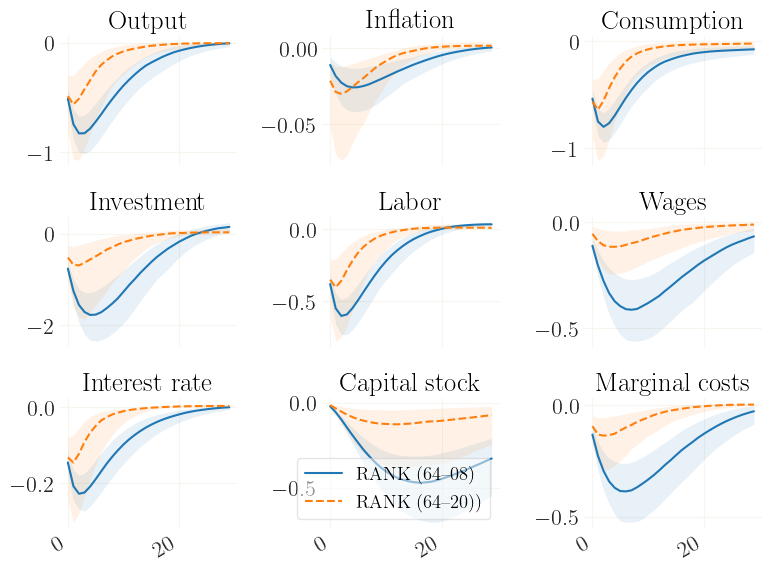

In [12]:
# plotting
fig, ax = figurator(3,3,1, figsize=(8,6))
pplot(irtup0, labels=vp, sigma=.1, alpha=.1, ax=ax, legend=('RANK (64--08)', 'RANK (64--20))'), styles=('-','--'))
ax[7].legend()
_ = [ f.tight_layout() for f in fig ]

## Figure 5

In [13]:
# simulate IRFs
ir10 = mod0.irfs(('e_i',-mod0.get_par('sig_i', pmea0),0), pars0)[0]
ir11 = mod1.irfs(('e_i',-mod1.get_par('sig_i', pmea1),0), pars1)[0]

# prepare for plotting
irtup1 = ir10[...,mod0.vix(v)], ir11[...,mod0.vix(v)]

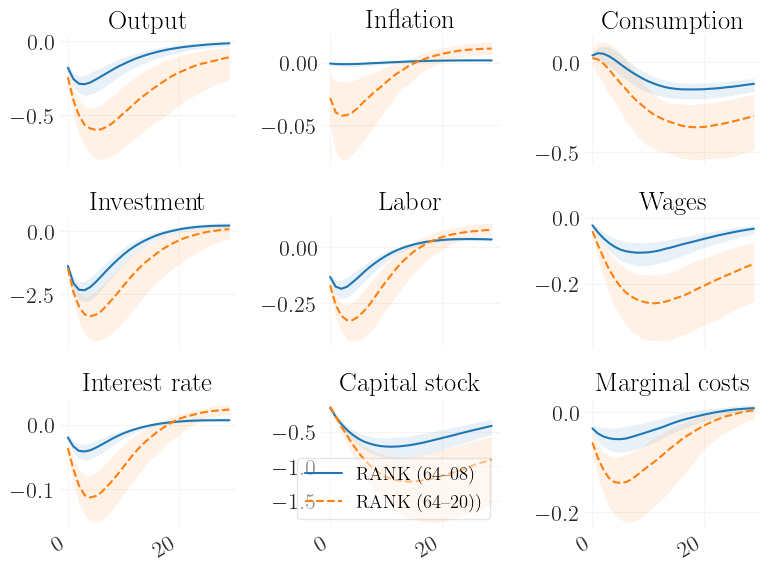

In [14]:
# plotting
fig, ax = figurator(3,3,1, figsize=(8,6))
pplot(irtup1, labels=vp, sigma=.1, alpha=.1, ax=ax, legend=('RANK (64--08)', 'RANK (64--20))'), styles=('-','--'))
ax[7].legend()
_ = [ f.tight_layout() for f in fig ]